# Import Libraries

In [15]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Input, MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os

In [16]:

BASE_DIR = "ScatteringMatrix"  # ganti sesuai foldermu
OUTPUT_NPY = "latent_rep/final_dataset_baru.npy"

In [17]:
print("TensorFlow version:", tf.__version__)
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.10.1
Built with CUDA: True
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [18]:
print("Physical GPUs:", tf.config.list_physical_devices("GPU"))
print("Logical GPUs:", tf.config.list_logical_devices("GPU"))

Physical GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Logical GPUs: [LogicalDevice(name='/device:GPU:0', device_type='GPU')]


In [19]:
tf.test.gpu_device_name()

'/device:GPU:0'

# All The Functions

In [20]:

def convert_xlsx_to_csv(base_dir, verbose=True):
    for i in range(1, 1001):
        folder = f"Scan{i}"
        folder_path = os.path.join(base_dir, folder)

        if not os.path.exists(folder_path):
            if verbose:
                print(f"⚠️ Folder {folder} does not exist, skipping")
            continue

        # Loop through all XLSX files in the folder
        for file_name in os.listdir(folder_path):
            if file_name.lower().endswith(".xlsx"):
                xlsx_path = os.path.join(folder_path, file_name)
                csv_file_name = file_name.rsplit('.', 1)[0] + ".csv"
                csv_path = os.path.join(folder_path, csv_file_name)

                try:
                    df = pd.read_excel(xlsx_path, header=None)  # load without headers
                    df.to_csv(csv_path, index=False, header=False)  # save as CSV
                    if verbose:
                        print(f"✅ Converted {xlsx_path} -> {csv_path}")
                except Exception as e:
                    print(f"❌ Failed to convert {xlsx_path}: {e}")


In [21]:
def load_and_stack_scans(base_dir, output_file="latent_rep/final_dataset_baru.npy", verbose=True):
    all_scans = []

    for i in range(1, 1001):
        folder = f'Scan{i}'
        folder_path = os.path.join(base_dir, folder)

        # Skip if folder doesn't exist or is empty
        if not os.path.exists(folder_path) or len(os.listdir(folder_path)) == 0:
            if verbose:
                print(f"⚠️ Skipping {folder} (missing or empty)")
            continue

        mag_file = os.path.join(folder_path, f"magnitude{i}.csv")
        phase_file = os.path.join(folder_path, f"phase{i}.csv")

        # Skip if files are missing
        if not os.path.isfile(mag_file) or not os.path.isfile(phase_file):
            if verbose:
                print(f"⚠️ Skipping {folder} (missing CSV files)")
            continue

        mag = pd.read_csv(mag_file, header=None, skiprows=1).values
        phase = pd.read_csv(phase_file, header=None, skiprows=1).values

        # Validate shape
        if mag.shape != (24, 24) or phase.shape != (24, 24):
            if verbose:
                print(f"⚠️ Shape mismatch in {folder}: mag {mag.shape}, phase {phase.shape}")
            continue

        # Stack magnitude and phase
        mag = np.expand_dims(mag, axis=-1)
        phase = np.expand_dims(phase, axis=-1)
        combined = np.concatenate([mag, phase], axis=-1)
        all_scans.append(combined)

    dataset = np.stack(all_scans, axis=0)
    np.save(output_file, dataset)

    if verbose:
        print(f"✅ Total valid scans collected: {len(all_scans)}")
        print(f"💾 Dataset saved! Shape: {dataset.shape}")

    return dataset


In [ ]:
def data_preparation():
    # Load dataset
    X_signal = np.load("latent_rep/final_dataset_baru.npy")  # shape (N, 24,24,2)
    # latent_rep = np.load("latent_rep/latent_all.npy")        # shape (N, latent_dim)

    # N = X_signal.shape[0]
    # indices = np.arange(N)

    # Split: train/test
    # train_idx, temp_idx = train_test_split(indices, test_size=0.3, random_state=42)
    # # Split temp_idx menjadi val/test dengan presisi
    # val_idx, test_idx = train_test_split(temp_idx, test_size=108, random_state=42)  # 108 val, 107 test

    # Ambil data sesuai indeks, urutan tetap sama
    X_signal_train = X_signal[:500]
    X_signal_val   = X_signal[500:607]
    X_signal_test  = X_signal[607:]

    latent_train = np.load('latent_rep/latent_train.npy')
    latent_val   = np.load('latent_rep/latent_val.npy')
    latent_test  = np.load('latent_rep/latent_test.npy')

    # Normalisasi latent
    scaler = StandardScaler()
    latent_train = scaler.fit_transform(latent_train)
    latent_val   = scaler.transform(latent_val)
    latent_test  = scaler.transform(latent_test)
    latent_rep = {'train': latent_train, 'val': latent_val, 'test': latent_test}

    X_signal_train[..., 0] /= X_signal_train[..., 0].max()
    X_signal_val[..., 0]   /= X_signal_train[..., 0].max() 
    X_signal_test[..., 0]  /= X_signal_train[..., 0].max()

    # Phase channel
    X_signal_train[..., 1] /= np.pi
    X_signal_val[..., 1]   /= np.pi
    X_signal_test[..., 1]  /= np.pi
    X_signal = {'train': X_signal_train, 'val': X_signal_val, 'test': X_signal_test}

    input_shape = X_signal_train.shape[1:]
    latent_dim  = latent_train.shape[1]

    return latent_rep, X_signal, input_shape, latent_dim

In [23]:
def create_cnn(input_shape, latent_dim):
  model = Sequential([
    Input(shape=input_shape),         # (24,24,2)
    Conv2D(16,(3,3),activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(32,(3,3),activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(64,(3,3),activation='relu'),
    Flatten(),
    Dense(512,activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(256,activation='relu'),   # sebelum latent
    Dense(latent_dim,activation='linear')  # latent_dim=256
  ])
  return model

In [24]:
def build_and_train_model(input_shape, latent_dim, latent_rep, X_signal):
  model = create_cnn(input_shape, latent_dim)
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss="mean_squared_error",
                metrics=["mean_squared_error"])

  lr_callback = callbacks.LearningRateScheduler(lambda epoch, lr: lr * 0.1 if epoch > 30 else lr)
  early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
  tensorboard_callback = callbacks.TensorBoard(log_dir="./logs", histogram_freq=1)
  model_checkpoint = callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor='val_loss')

  callbacks_list = [lr_callback, early_stopping, tensorboard_callback, model_checkpoint]

  # Train the model
  with tf.device('/GPU:0'):
      history = model.fit(
          X_signal['train'], latent_rep['train'],
          validation_data=(X_signal['val'], latent_rep['val']),
          epochs=30,
          batch_size=2,
          callbacks=callbacks_list
      )

  model.save("model_final.keras")
  return history, model

In [25]:
def evaluate_model(model, signal_test, latent_test):
  test_loss = model.evaluate(signal_test, latent_test, batch_size=2)
  print(f"Test Loss (MSE): {test_loss}")

In [26]:
def visualize_training(history):
  plt.plot(history.history['mean_squared_error'], label='Training Loss')
  plt.plot(history.history['val_mean_squared_error'], label='Validation Loss')
  plt.title('Model Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss (MSE)')
  plt.legend()
  plt.show()

In [27]:
def pipeline():
  # convert_xlsx_to_csv(BASE_DIR)
  load_and_stack_scans(BASE_DIR)
  latent_rep, X_signal, input_shape, latent_dim = data_preparation()
  # print("Train X:", X_signal['train'].shape)
  # print("Train Y:", latent_rep['train'].shape)
  # print("Val X:", X_signal['val'].shape)
  # print("Val Y:", latent_rep['val'].shape)
  # print("Test X:", X_signal['test'].shape)
  # print("Test Y:", latent_rep['test'].shape)
  history, model_final = build_and_train_model(input_shape, latent_dim, latent_rep, X_signal)
  evaluate_model(model_final, X_signal['test'], latent_rep['test'])
  visualize_training(history)

# Implementation

⚠️ Skipping Scan216 (missing or empty)
⚠️ Skipping Scan217 (missing or empty)
⚠️ Skipping Scan218 (missing or empty)
⚠️ Skipping Scan219 (missing or empty)
⚠️ Skipping Scan220 (missing or empty)
⚠️ Skipping Scan221 (missing or empty)
⚠️ Skipping Scan222 (missing or empty)
⚠️ Skipping Scan223 (missing or empty)
⚠️ Skipping Scan224 (missing or empty)
⚠️ Skipping Scan225 (missing or empty)
⚠️ Skipping Scan226 (missing or empty)
⚠️ Skipping Scan227 (missing or empty)
⚠️ Skipping Scan228 (missing or empty)
⚠️ Skipping Scan229 (missing or empty)
⚠️ Skipping Scan230 (missing or empty)
⚠️ Skipping Scan231 (missing or empty)
⚠️ Skipping Scan232 (missing or empty)
⚠️ Skipping Scan233 (missing or empty)
⚠️ Skipping Scan234 (missing or empty)
⚠️ Skipping Scan235 (missing or empty)
⚠️ Skipping Scan236 (missing or empty)
⚠️ Skipping Scan237 (missing or empty)
⚠️ Skipping Scan238 (missing or empty)
⚠️ Skipping Scan239 (missing or empty)
⚠️ Skipping Scan240 (missing or empty)
⚠️ Skipping Scan241 (miss

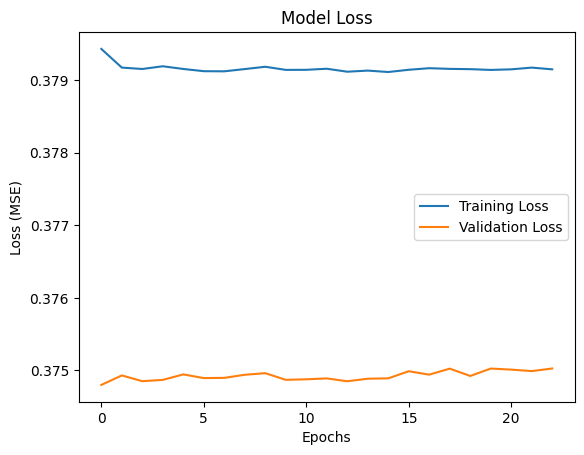

In [28]:
pipeline()